In [1]:
import numpy as np
import pylab as pb
import GPy
import copy as cp

regenerate = True

pb.ion()

file_base = ""

In [2]:
X_raw = Y_raw = None
segment = True

if segment:
    backup_size = 50
    file_ending = "_backup_i" + str(backup_size - 1) + "_G6.npy"
    X_raw = np.load(file_base + "hc" + file_ending, allow_pickle=True)
    Y_raw = np.load(file_base + "samples" + file_ending, allow_pickle=True)
    X_raw = X_raw[:backup_size]
    Y_raw = Y_raw[:backup_size]
else:
    X_raw = np.load("hc_G6.npy", allow_pickle=True)
    Y_raw = np.load("samples_G6", allow_pickle=True)

In [3]:
scales = np.load("../standard_k.npy", allow_pickle=True)

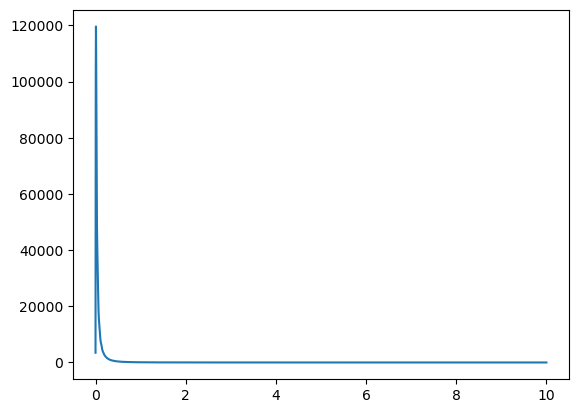

In [4]:
# This plot only serves to make sure that the first row actually describes a
# function.
pb.plot(scales, Y_raw[0])

In [5]:
def is_bad(row):
    if float('-inf') in row or float('inf') in row \
        or None in row or True in np.isnan(pspec) \
        or 0 in row:
        return True
    return False

bad_row_indices = []
for i in range(len(Y_raw)):
    pspec = Y_raw[i]
    if is_bad(pspec):
        bad_row_indices.append(i)

X = np.delete(X_raw, bad_row_indices, 0)
Y = np.delete(Y_raw, bad_row_indices, 0)

In [6]:
# Now the goal is to compute summary statistics on Y for each value k
Ylog = np.log(Y)
mu = np.mean(Ylog, axis=0)
mu.shape
stdev = np.std(Ylog, axis=0)
stdev.shape

(300,)

In [7]:
# now normalize the data with these summary statistics
Y_normalized = cp.deepcopy(Ylog)

for i in range(len(Y)):
    Y_normalized[i] -= mu
    Y_normalized[i] /= stdev

In [8]:
def inverse_transform(raw_prediction):
    return np.exp(raw_prediction * stdev + mu)

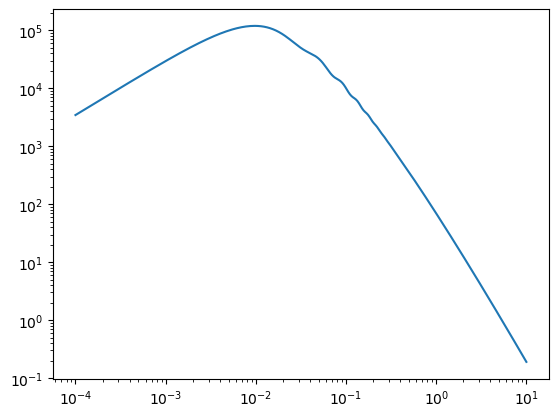

In [9]:
pb.loglog(scales, inverse_transform(Y_normalized[0]))

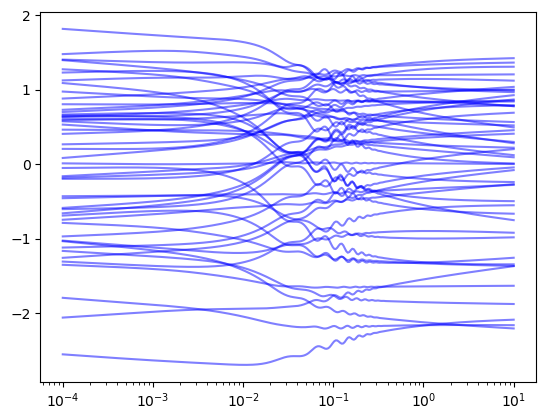

In [10]:
for i in range(len(X)):
    pb.plot(scales, Y_normalized[i], alpha=0.5, color='blue')
pb.xscale('log')

In [11]:
print(X.shape, Y_normalized.shape)

(50, 6) (50, 300)


In [12]:
kernel = GPy.kern.RBF(input_dim=6, variance=1., lengthscale=1.)
m = GPy.models.GPRegression(X,Y_normalized,kernel)

In [13]:
import importlib.util
import sys
spec = importlib.util.spec_from_file_location(
    "camb_interface", "../../../cassL/camb_interface.py")
ci = importlib.util.module_from_spec(spec)
sys.modules["camb_interface"] = ci
spec.loader.exec_module(ci)

test_omnuh2 = 0.002

m0_without_neuts = ci.specify_neutrino_mass(ci.cosm.iloc[0], 0, 0)
m0_with_neuts = ci.specify_neutrino_mass(ci.cosm.iloc[0], test_omnuh2, 1)

m0_with_neuts['omch2'] -= test_omnuh2

In [14]:
# We'll need to check our work using CAMB
p_true_interpolator = ci.andrea_interpolator(m0_with_neuts)#,
#    redshifts=[0], kmax=10)
p_m0truth = np.array([p_true_interpolator.P(0, k) for k in scales])

s_m0truth = ci.s12_from_interpolator(p_true_interpolator, 0)

m0_without_neuts['sigma12'] = m0_with_neuts['sigma12'] = s_m0truth

print(s_m0truth)

nnu_massive: 1
0.7864558724216139


In [15]:
spec = importlib.util.spec_from_file_location(
    "generate_emu_data", "../../../cassL/generate_emu_data.py")
ged = importlib.util.module_from_spec(spec)
sys.modules["generate_emu_data"] = ged
spec.loader.exec_module(ged)

In [16]:
p_m0truth2, actual_sigma12, best_z = ged.interpolate_cell(m0_with_neuts, scales)

nnu_massive: 0
nnu_massive: 1


In [17]:
import pickle

if regenerate:
    #assert False, "you should give this emulator a new name instead of over-writing"
    m.constrain_positive('') # '' is a regex matching all parameter names
    m.optimize()
    
    m.mu = mu
    m.stdev = stdev
    pickle.dump(m, open("analyses/massive_emulator_G6_50.nucomet", "wb"), protocol=5) 
else:
    m = pickle.load(open("analyses/massive_emulator_G6_50.nucomet", "rb"))

In [18]:
# Remember that the structure of an hc entry is DIFFERENT NOW
# omb, omc, ns, s12, As, omnu
x = np.array([np.array([
    m0_with_neuts['ombh2'], m0_with_neuts['omch2'], m0_with_neuts['n_s'],
    s_m0truth, m0_with_neuts['A_s'], m0_with_neuts['omnuh2']
])])
x

array([[2.24450000e-02, 1.18567000e-01, 9.60000000e-01, 7.86455872e-01,
        2.12723788e-09, 2.00000000e-03]])

In [19]:
guess, uncertainties = m.predict(x)

Text(0.5, 0, 'scale $k$ [1 / Mpc]')

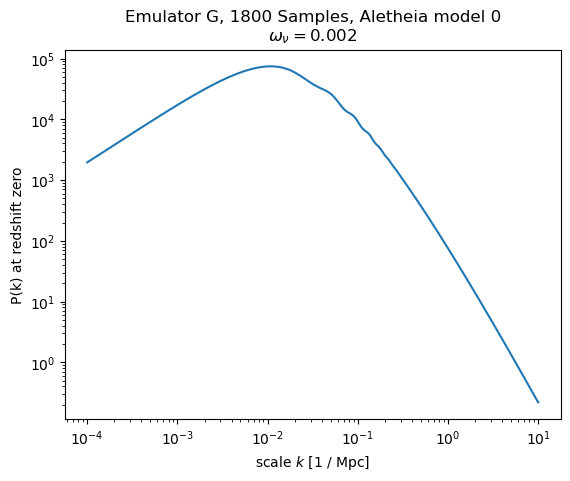

In [20]:
#import matplotlib.pyplot as plt
pb.loglog(scales, inverse_transform(guess[0]))
pb.title("Emulator G, 1800 Samples, Aletheia model 0\n" + r"$\omega_\nu=0.002$")
pb.ylabel('P(k) at redshift zero')
pb.xlabel('scale $k$ [1 / Mpc]')

Text(0.5, 0, 'scale $k$ [1 / Mpc]')

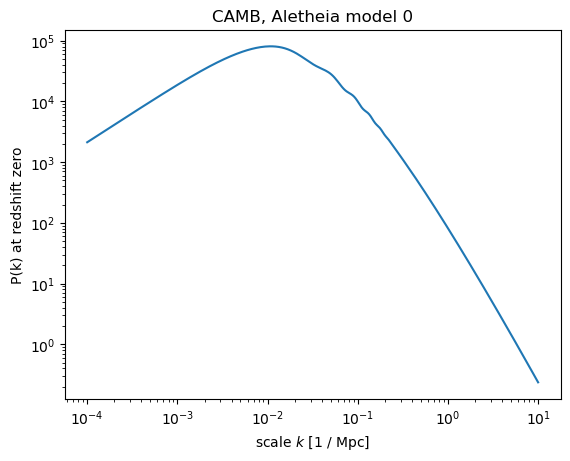

In [21]:
#import matplotlib.pyplot as plt
pb.loglog(scales, p_m0truth)
pb.title("CAMB, Aletheia model 0")
pb.ylabel('P(k) at redshift zero')
pb.xlabel('scale $k$ [1 / Mpc]')

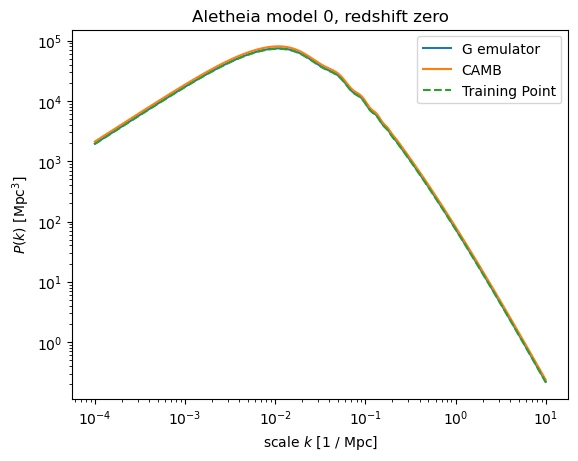

In [22]:
pb.plot(scales, inverse_transform(guess[0]),
    label="G emulator")
pb.loglog(scales, p_m0truth, label="CAMB")
pb.loglog(scales, p_m0truth2, label="Training Point", linestyle='dashed')
pb.title("Aletheia model 0, redshift zero")
pb.ylabel('$P(k)$ [Mpc$^3$]')
pb.xlabel('scale $k$ [1 / Mpc]')
pb.legend()

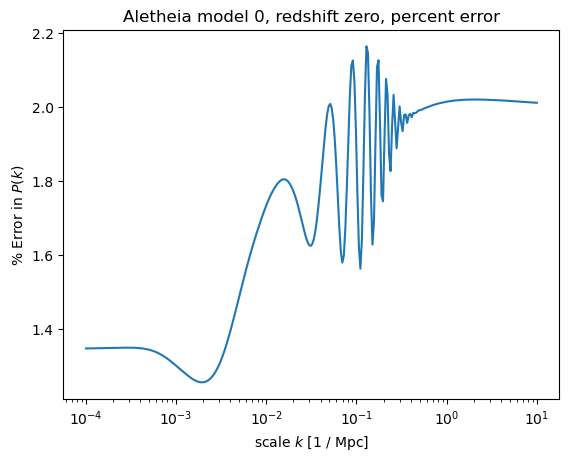

In [34]:
pb.plot(scales,
    (inverse_transform(guess[0]) - p_m0truth2) / p_m0truth2 * 100)
pb.xscale('log')
pb.title("Aletheia model 0, redshift zero, percent error")
pb.ylabel('% Error in $P(k)$')
pb.xlabel('scale $k$ [1 / Mpc]')
pb.savefig("../../plots/emulator/performance/massive_m0_G5.png")

In [24]:
# Remember that the structure of a hc entry is
# omb, omc, ns, s12, omnu, As
x_hi_ns = np.array([np.array([
    0.022445, 0.120567, 1.01, 0.82466774,
    2.12723788013000E-09, 0
])])
guess_hi_ns, uncertainties_hi_ns = m.predict(x_hi_ns)
x_lo_ns = np.array([np.array([
    0.022445, 0.120567, 0.92, 0.82466774,
    2.12723788013000E-09, 0
])])
guess_lo_ns, uncertainties_lo_ns = m.predict(x_lo_ns)


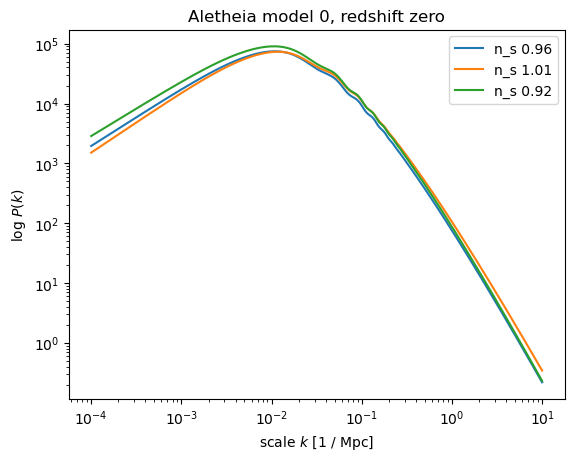

In [25]:
pb.loglog(scales, inverse_transform(guess[0]), label="n_s 0.96")
pb.loglog(scales, inverse_transform(guess_hi_ns[0]), label="n_s 1.01")
pb.loglog(scales, inverse_transform(guess_lo_ns[0]), label="n_s 0.92")

pb.title("Aletheia model 0, redshift zero")
pb.ylabel('log $P(k)$')
pb.xlabel('scale $k$ [1 / Mpc]')
pb.legend()

In [26]:
# Remember that the structure of a hc entry is
# omb, omc, ns, s12, omnu, As
omnu_hi = 0.01
x_hi_omnu = np.array([np.array([
    0.022445, 0.120567 - omnu_hi, 0.96, 0.82466774,
    2.12723788013000E-09, omnu_hi
])])
guess_hi_omnu, uncertainties_hi_omnu = m.predict(x_hi_omnu)

omnu_mid = 0.002148659574468
x_mid_omnu = np.array([np.array([
    0.022445, 0.120567 - omnu_mid, 0.96, 0.82466774,
    2.12723788013000E-09, omnu_mid,
])])
guess_mid_omnu, uncertainties_mid_omnu = m.predict(x_mid_omnu)


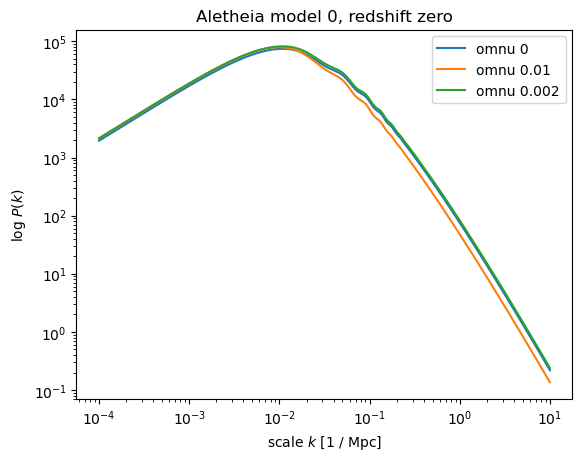

In [27]:
pb.loglog(scales, inverse_transform(guess[0]),
          label="omnu 0")
pb.loglog(scales, inverse_transform(guess_hi_omnu[0]),
          label="omnu 0.01")
pb.loglog(scales, inverse_transform(guess_mid_omnu[0]),
          label="omnu 0.002")

pb.title("Aletheia model 0, redshift zero")
pb.ylabel('log $P(k)$')
pb.xlabel("scale $k$ [1 / Mpc]")
pb.legend()

In [28]:
# Remember that the structure of a hc entry is
# omb, omc, ns, s12, omnu, As
x_hi_omb = np.array([np.array([
    0.02415, 0.120567, 0.96, 0.82466774,
    2.12723788013000E-09, 0
])])
guess_hi_omb, uncertainties_hi_omb = m.predict(x_hi_omb)

x_lo_omb = np.array([np.array([
    0.0205, 0.120567, 0.96, 0.82466774,
    2.12723788013000E-09, 0
])])
guess_lo_omb, uncertainties_lo_omb = m.predict(x_lo_omb)


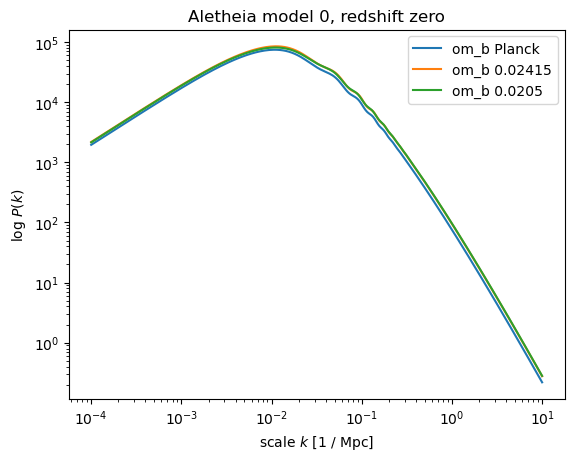

In [29]:
pb.loglog(scales, inverse_transform(guess[0]),
        label="om_b Planck")
pb.loglog(scales, inverse_transform(guess_hi_omb[0]),
        label="om_b 0.02415")
pb.loglog(scales, inverse_transform(guess_lo_omb[0]),
        label="om_b 0.0205")

pb.title("Aletheia model 0, redshift zero")
pb.ylabel('log $P(k)$')
pb.xlabel("scale $k$ [1 / Mpc]")
pb.legend()

In [30]:
# Remember that the structure of a hc entry is
# omb, omc, ns, s12, omnu, As
x_hi_omc = np.array([np.array([
    0.022445, 0.155, 0.96, 0.82466774,
    2.12723788013000E-09, 0
])])
guess_hi_omc, uncertainties_hi_omc = m.predict(x_hi_omc)

x_lo_omc = np.array([np.array([
    0.022445, 0.085, 0.96, 0.82466774,
    2.12723788013000E-09, 0
])])
guess_lo_omc, uncertainties_lo_omc = m.predict(x_lo_omc)


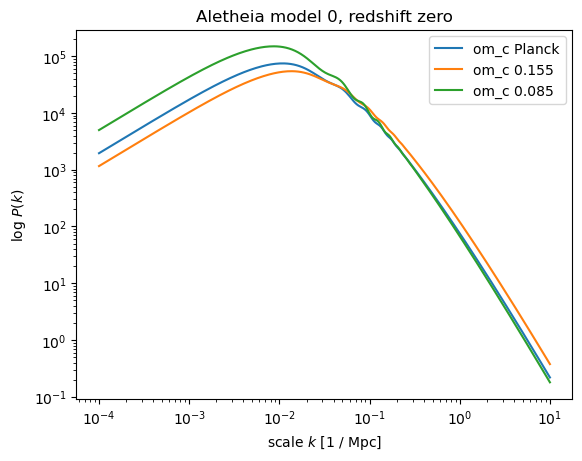

In [31]:
pb.loglog(scales, inverse_transform(guess[0]),
        label="om_c Planck")
pb.loglog(scales, inverse_transform(guess_hi_omc[0]),
        label="om_c 0.155")
pb.loglog(scales, inverse_transform(guess_lo_omc[0]),
        label="om_c 0.085")

pb.title("Aletheia model 0, redshift zero")
pb.ylabel('log $P(k)$')
pb.xlabel("scale $k$ [1 / Mpc]")
pb.legend()

In [32]:
# Remember that the structure of a hc entry is
# omb, omc, ns, s12, omnu, As
x_hi_As = np.array([np.array([
    0.022445, 0.120567, 0.96, 0.82466774,
    np.exp(3.91) / 10 ** 10, 0
])])
guess_hi_As, uncertainties_hi_As = m.predict(x_hi_As)
x_lo_As = np.array([np.array([
    0.022445, 0.120567, 0.96, 0.82466774,
    np.exp(2.35) / 10 ** 10, 0
])])
guess_lo_As, uncertainties_lo_As = m.predict(x_lo_As)

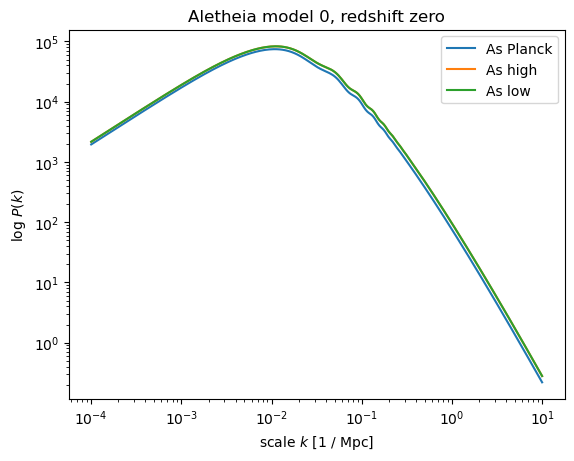

In [33]:
pb.loglog(scales, inverse_transform(guess[0]), label="As Planck")
pb.loglog(scales, inverse_transform(guess_hi_As[0]), label="As high")
pb.loglog(scales, inverse_transform(guess_lo_As[0]), label="As low")

pb.title("Aletheia model 0, redshift zero")
pb.ylabel('log $P(k)$')
pb.xlabel("scale $k$ [1 / Mpc]")
pb.legend()

I guess this shows that sigma12 countermands As, huh?